HHU Deep Learning, SS2024, 26.04.2024, Prof. Dr. Markus Kollmann

Lecturers and Tutoring is done by Nikolas Adaloglou and Felix Michels.

# Assignment 03 - Language Representations using BERT

---

Submit the solved notebook (not a zip) with your full name plus assingment number for the filename as an indicator, e.g `max_mustermann_a1.ipynb` for assignment 1. 
This is a **two week** exercise.
If we feel like you have genuinely tried to solve the exercise, you will receive **2** points for this assignment, regardless of the quality of your solution.

## <center> DUE FRIDAY 10.05.2024 2:30 pm </center>

Drop-off link: [https://uni-duesseldorf.sciebo.de/s/utl58K0qjqwD6yz](https://uni-duesseldorf.sciebo.de/s/utl58K0qjqwD6yz)

---

## Contents

1. Preparation and imports
2. Data Preparation
3. The pair dataset
4. Masking
5. The model
6. Training
7. Evaluating the model
8. Conclusion and bonus read

# Overview

In this exercie you will train a small [BERT](https://arxiv.org/abs/1810.04805) model on the IMDB dataset (https://huggingface.co/datasets/imdb).
You will then use the model to classify the sentiment of movie reviews and the sentiment of sentences from the Stanford Sentiment Treebank (SST2, https://huggingface.co/datasets/sst2).

# Part I. Preparation and imports

In [39]:
!wget -nc https://raw.githubusercontent.com/HHU-MMBS/RepresentationLearning_PUBLIC_2024/main/exercises/week03/utils.py

File ‘utils.py’ already there; not retrieving.



In [1]:
!wget -nc https://raw.githubusercontent.com/HHU-MMBS/RepresentationLearning_PUBLIC_2024/main/exercises/week03/requirements.txt

File 'requirements.txt' already there; not retrieving.



In [1]:
# You may need to install some additional packages
!pip install -r requirements.txt

In [2]:
# basic imports
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

# local imports
from utils import load_imdb_dataset, load_sst2_dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Part II. Data Preparation

## The Tokenizer
To use text in a neural network, we need to convert it to numbers. This is done by a tokenizer. The tokenizer splits the text into tokens and maps each token to an integer. The tokenizer also adds special tokens to the beginning and end of the sentence. These special tokens are used to indicate the beginning and end of the sentence and to separate two sentences.
You won't need to use a tokenizer directly, but you should go through this section to get a better understanding of how it works.
We'll use a variant of WordPiece tokenization, which is used by BERT. The tokenizer is implemented in the `transformers` library. For more information, see [here](https://huggingface.co/course/chapter6/6?fw=pt).

In [3]:
from utils import TOKENIZER

Common words are just tokens themselves

In [4]:
TOKENIZER.tokenize('These are just common words')

['these', 'are', 'just', 'common', 'words']

Less common words are split into subwords. This way we can represent rare words with a few tokens and still have a fixed vocabulary size.
We also don't have to worry about encountering new words that are not in the vocabulary.

In [5]:
TOKENIZER.tokenize('Gerbils are crepuscular')

['ge', '##rb', '##ils', 'are', 'cr', '##ep', '##us', '##cular']

### Special tokens and turn to ids
Special tokens are indicated by brackets `[]`. These are the relevant special tokens:

| Token  | Purpose                                              |
|--------|------------------------------------------------------|
| [CLS]  | The first token is always classification             |
| [SEP]  | At the end of each sentence                          |
| [PAD]  | Use to pad sentences to the same length              |
| [MASK] | Used to create a mask by replacing the original word |

When using the tokenizer on a list of sentence pairs, it will automatically add the special tokens and separate the sentences as well as pad the sentences to the same length.

In [6]:
sentence_pairs = [
    ['hello world', 'what a nice day'],
    ['this is a slightly longer sentence', 'it really is'],
    ['And this is a third sentence', 'just for good measure']
]

first_sentences, second_sentences = zip(*sentence_pairs)

out = TOKENIZER(first_sentences, second_sentences, padding=True, return_tensors='pt', truncation=True, return_special_tokens_mask=True, return_attention_mask=False)
input_ids = out['input_ids']
segment_ids = out['token_type_ids']
special_tokens_mask = out['special_tokens_mask']

In [7]:
# The input ids are just numbers, one number for each token.
input_ids

tensor([[ 101, 7592, 2088,  102, 2054, 1037, 3835, 2154,  102,    0,    0,    0,
            0],
        [ 101, 2023, 2003, 1037, 3621, 2936, 6251,  102, 2009, 2428, 2003,  102,
            0],
        [ 101, 1998, 2023, 2003, 1037, 2353, 6251,  102, 2074, 2005, 2204, 5468,
          102]])

In [8]:
print(f"The tokenizer assigns ids between 0 and {TOKENIZER.vocab_size}")

The tokenizer assigns ids between 0 and 30522


In [9]:
# We can decode the input ids to get the original text together with the special tokens
TOKENIZER.decode(input_ids[0])

'[CLS] hello world [SEP] what a nice day [SEP] [PAD] [PAD] [PAD] [PAD]'

In [10]:
# The segment ids indicate which sentence each token belongs to. 0 is the first sentence, 1 is the second sentence.
# Note that we could get this information just by looking at the [SEP] tokens
segment_ids[0]

tensor([0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0])

In [11]:
# Get just the first sentence
TOKENIZER.decode(input_ids[0][segment_ids[0] == 0])

'[CLS] hello world [SEP] [PAD] [PAD] [PAD] [PAD]'

In [12]:
# Get just the second sentence
TOKENIZER.decode(input_ids[0][segment_ids[0] == 1])

'what a nice day [SEP]'

In [13]:
# The special tokens mask indicates which tokens are special tokens
# Just the special tokens
TOKENIZER.decode(input_ids[0][special_tokens_mask[0] == 1])

'[CLS] [SEP] [SEP] [PAD] [PAD] [PAD] [PAD]'

In [14]:
# Only the normal tokens
TOKENIZER.decode(input_ids[0][special_tokens_mask[0] == 0])

'hello world what a nice day'

## Loading The Data


- Each entry in the IMDb dataset `dataset = load_imdb_dataset()` corresponds to a movie review consisting of a list of sentences. Since they are tokenized, each entry is a list of tensors containing integers.

- We can use the `decode` method of the tokenizer to get the original sentences from the tokens.

- Performance-related info: For performance reasons, we will use precomputed tokens. This means that we will not use the tokenizer directly, but instead use the precomputed tokens that are stored in the dataset. When you load the dataset for the first time, it will download the dataset and tokenize it. This may take 2-5 minutes. The tokens will be saved in a cache directory, so the next time you load the dataset, it will be faster.

- Feel free to look into `utils.py` to see what's actually going on

In [15]:
dataset = load_imdb_dataset()
print('Number of training samples corresponding to movie reviews:', len(dataset))
print("Each data instance (training sample) in the dataset is a list of tokenized sentences with len", len(dataset[0]))

print("The tokenized sentences are lists of token ids:")
for c, tokens in enumerate(dataset[0]):
    print(c, tokens)
    if c == 4:
        break

print("\n The corresponding decoded text for the same training sample is:")
for c, tokens in enumerate(dataset[0]):
    print(c, TOKENIZER.decode(tokens), "\n")
    if c == 4:
        break

Number of training samples corresponding to movie reviews: 50000
Each data instance (training sample) in the dataset is a list of tokenized sentences with len 14
The tokenized sentences are lists of token ids:
0 tensor([2023, 2003, 2074, 1037, 9062, 2210, 6323], dtype=torch.int16)
1 tensor([1996, 2377, 1996, 5896, 2024, 6581], dtype=torch.int16)
2 tensor([ 1045,  2064,  2102, 12826,  2023,  3185,  2007,  2505,  2842,  2672,
         3272,  1996,  3185,  6506,  6919,  2135,  2209,  2011,  3744, 17738,
         1998, 10829,  3417,  2386], dtype=torch.int16)
3 tensor([2021, 2054, 2064, 1045, 2360, 2055, 2023, 2028], dtype=torch.int16)
4 tensor([ 2023,  2003,  1996,  2190,  3185,  4776, 11968,  9386,  6784,  2038,
         2412,  2209,  1999,  2156,  3531, 12784,  2732,  7138,  2016,  1005,
         1055,  4092,  2394,  2045,  2000,  2156,  2054,  1045,  2812],
       dtype=torch.int16)

 The corresponding decoded text for the same training sample is:
0 this is just a precious little diamo

The text only contains lower case letters and most punctuation has been removed. 

This helps because you will use a relatively small model and a small dataset.

Since we use precomputed tokens, we cannot use the tokenizer to add special tokens. Instead, we will use the `add_special_tokens` function from the `utils` module.
This function takes two tokenized sentences, adds the special tokens and concatenates them.
It returns a dictionary with the keys:
- `input_ids` and `segment_ids` like in the previous section.
- The key `normal_mask` is the inverse of the `special_tokens_mask` from the previous section. It indicates which tokens are not special tokens and should only have three `True` entries: `[CLS]` at the beginning, `[SEP]` between the sentences and `[SEP]` at the end.

Again, we can use the `decode` method of the tokenizer to get the original text from the tokens.

In [16]:
from utils import add_special_tokens
out = add_special_tokens(dataset[0][0], dataset[5][6])
print(out)
print(TOKENIZER.decode(out['input_ids']))

{'input_ids': tensor([  101,  2023,  2003,  2074,  1037,  9062,  2210,  6323,   102,  2200,
         2779,  5095,  2258,  2654,  2889,  1011, 28352, 11761,  5988,   102]), 'normal_mask': tensor([False,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False]), 'segment_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])}
[CLS] this is just a precious little diamond [SEP] very average saturday april 28 1991 - balwyn cinema [SEP]


Finally, all sequences will be limited by the hyper-parameter `MAX_SEQ_LEN` (again, for performance reasons).

In [17]:
from utils import MAX_SEQ_LEN
print(f"Maximum sequence length: {MAX_SEQ_LEN}")

Maximum sequence length: 256


# Part III: The pair dataset

One of the pretext tasks in BERT is to train on next sentence prediction: whether 2 sentences come from the same text.

For this we need a dataset that contains pairs of sentences, some of which are consecutive sentences from the same text and some of which are random sentences from different texts.

### Task 1 - Implement the `IMDbPairDataset` class. 

Each item in this dataset are a random pair of tokenized sentences from the IMDb dataset. Because this dataset return random pairs, we will not use a standard `torch.utils.data.DataSet` class, but the subclass `torch.utils.data.IterableDataset` ([documentation](https://pytorch.org/docs/stable/data.html#torch.utils.data.IterableDataset)).

We also want to make sure that the sentences are not too short or too long. The `min_len` and `max_len` arguments specify the minimal and maximal length of the combined sentences.
You can just sample inside a loop until you find a pair of sentences that satisfies the length constraints.
If you want, try to find a more efficient way to do this.

Recall, that each entry in the IMDb dataset is a list of tokenized sentences. Therefore, each sentence is described by a *pair* of indices: the index of the text (movie review) and the index of the sentence inside the text.

Please read the method docstrings that give you further instructions.

For sampling, we used `np.random.randint()` so you need to sample with the same function to get our expected result.

In [18]:
class IMDbPairDataset(torch.utils.data.IterableDataset):

    def __init__(self, min_len=0, max_len=MAX_SEQ_LEN, p_next=0.5, train=True):
        """
        Args:
            min_len: minimal length of both combined sentences
            max_len: maximal length of both combined sentences
            p_next: probability that the second sentence is the next sentence in the text
            train: whether to use the train or test dataset
        """
        self.max_len = max_len
        self.min_len = min_len
        self.dataset = load_imdb_dataset(train)
        self.p_next = p_next

    def sample_next_idx(self):
        """
        Sample two pair of indices corresponding to two consecutive sentences from the dataset, i.e.,
        the second sentence is the next sentence in the same text as the first sentence.
        Note, that some texts only have one sentence. In this case, you should sample again.

        Returns:
            two tuples of the form (text_idx, sent_idx), (text_idx, sent_idx + 1)
        """
        ### START CODE HERE ### (≈ 5 lines of code)
        text_idx = np.random.randint(0, len(self.dataset))
        while len(self.dataset[text_idx]) < 2:
            text_idx = np.random.randint(0, len(self.dataset))
        sentences = self.dataset[text_idx]
        sent_idx = np.random.randint(0, len(sentences) - 1)
        ### END CODE HERE ###
        return (text_idx, sent_idx), (text_idx, sent_idx + 1)

    def sample_random_idx(self):
        """
        Sample two pair of indices corresponding to two random sentences from the dataset.

        Returns:
            two tuples of the form (text_idx_a, sent_idx_a), (text_idx_b, sent_idx_b)
        """
        ### START CODE HERE ### (≈ 6 lines of code)
        text_idx_a = np.random.randint(0, len(self.dataset))
        sentences_a = self.dataset[text_idx_a]
        sent_idx_a = np.random.randint(0, len(sentences_a))
        text_idx_b = np.random.randint(0, len(self.dataset))
        sentences_b = self.dataset[text_idx_b]
        sent_idx_b = np.random.randint(0, len(sentences_b))
        ### END CODE HERE ###
        return (text_idx_a, sent_idx_a), (text_idx_b, sent_idx_b)

    def sample_tokens(self, is_next):
        """
        Samples a pair of sentences from the dataset by first sampling indices and then using the `add_special_tokens` function.
        Args:
            is_next: if True, the second sentence is the next sentence in the same movie review.
                     if False, the second sentence is a random sentence from a random movie review.

        Returns:
            A dictionary with the keys 'input_ids', 'segment_ids' and 'normal_mask'.
            The values are tensors of the same length without length restriction.

        """
        if is_next:
            (text_idx_a, sent_idx_a), (text_idx_b, sent_idx_b) = self.sample_next_idx()
        else:
            (text_idx_a, sent_idx_a), (text_idx_b, sent_idx_b) = self.sample_random_idx()
        tokens_a = self.dataset[text_idx_a][sent_idx_a]
        tokens_b = self.dataset[text_idx_b][sent_idx_b]
        return add_special_tokens(tokens_a, tokens_b)

    def sample(self):
        """
        Samples a random pair of sentences from the dataset.
        With probability p_next, the second sentence is the next sentence in the same movie review.
        With probability 1 - p_next, the second sentence is a random sentence from a random movie review.

        Returns:
            A dictionary with the keys 'input_ids', 'segment_ids', 'normal_mask'
            and 'is_next' (boolean, indicates whether the second sentence is the next sentence in the same movie review).
            The values are tensors of the same length, but at least min_len and at most max_len.
        """
        is_next = np.random.rand() < self.p_next
        out = self.sample_tokens(is_next)
        while not (self.min_len <= len(out['input_ids']) <= self.max_len):
            out = self.sample_tokens(is_next)
        out.update(is_next=is_next)
        return out

    def __iter__(self):
        while True:
            yield self.sample()

def test_IMDbPairDataset():
    np.random.seed(999)
    torch.manual_seed(999)
    dataset = IMDbPairDataset()
    for sample in dataset:
        print("Each training sample contains the following keys:", list(sample.keys()), "\n")
        print("Is next:", sample['is_next'])
        print(TOKENIZER.decode(sample['input_ids']))
        break

test_IMDbPairDataset()

Each training sample contains the following keys: ['input_ids', 'normal_mask', 'segment_ids', 'is_next'] 

Is next: False
[CLS] actually i'd like to see a celebrity death match with rambo and braddock though it wouldn't be much of a fight and then there's good old chuck norris who for some reason a few people find entertaining but honestly the greatest entertainment he gives me is the chuck norris facts this film is pretty easy to laugh at though but i don't think it was meant to be funny [SEP] nick nolte and others involved with the movie vowed never to work with eddie murphy again [SEP]


### Expected result

Note: You might get a different result based on your implementation of the random samling.

```
Each training sample contains the following keys: ['input_ids', 'normal_mask', 'segment_ids', 'is_next'] 

Is next: False

[CLS] actually i'd like to see a celebrity death match with rambo and braddock though it wouldn't be much of a fight and then there's good old chuck norris who for some reason a few people find entertaining but honestly the greatest entertainment he gives me is the chuck norris facts this film is pretty easy to laugh at though but i don't think it was meant to be funny [SEP] nick nolte and others involved with the movie vowed never to work with eddie murphy again [SEP]
```


### Making a dataloader

Let's try putting our dataset into a PyTorch dataloader and loading a batch

In [19]:
dataset = IMDbPairDataset()
loader = DataLoader(dataset, batch_size=128)
batch = next(iter(loader))

RuntimeError: stack expects each tensor to be equal size, but got [25] at entry 0 and [163] at entry 1

**Oh no!** That didn't work (most likely). The fault lies in the *collate function*. This function takes a list of items from the dataset and tries to combine them in a sensible way. However, it fails because the items returned by our dataset have different lenghts.

We need some custom collate function that adds padding. We already provided that for you in `utils.py`.
One way to use it, is to modify the `padded_collate_tensor_fn` dictionary ([This is actually one of the recommended ways to do this](https://github.com/pytorch/pytorch/blob/107f944f226554a52d4028b37b35bcc07b427cc7/torch/utils/data/_utils/collate.py#L310))

In [20]:
from torch.utils.data._utils.collate import default_collate_fn_map
from utils import padded_collate_tensor_fn

# Modify the collate map. This will change the behavior of the DataLoader!
default_collate_fn_map[torch.Tensor] = padded_collate_tensor_fn

In [21]:
# Now it will work
dataset = IMDbPairDataset()
loader = DataLoader(dataset, batch_size=128)
batch = next(iter(loader))
batch

{'input_ids': tensor([[ 101, 2957, 2852,  ...,    0,    0,    0],
         [ 101, 1996, 3185,  ...,    0,    0,    0],
         [ 101, 2074, 1037,  ...,    0,    0,    0],
         ...,
         [ 101, 2008, 4066,  ...,    0,    0,    0],
         [ 101, 2036, 2122,  ...,    0,    0,    0],
         [ 101, 1045, 2064,  ...,    0,    0,    0]]),
 'normal_mask': tensor([[False,  True,  True,  ..., False, False, False],
         [False,  True,  True,  ..., False, False, False],
         [False,  True,  True,  ..., False, False, False],
         ...,
         [False,  True,  True,  ..., False, False, False],
         [False,  True,  True,  ..., False, False, False],
         [False,  True,  True,  ..., False, False, False]]),
 'segment_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 'is_next': tensor([False, 

# Part IV: Masking

The other pretext task BERT is trained on is *masked language modeling*, in which some tokens are replaced by a special `[MASK]` token and the model is trained to predict the original token.

### Task 2: Implement the `BERTMasker` class, which takes a sequence of tokens and masks some of them.



The masking procedure is as follows:
First, select the tokens to be randomly masked with probability `p_select`. 

`Note`: Only consider tokens that are "normal", i.e., not special tokens (i.e., not `[CLS]`, `[SEP]` or `[PAD]`). Use the `normal_mask` to achieve this.

Second, for each selected masked token there are three possibilities: replace it with a random token (with prob. `p_rand`), mask it by using the token TOKENIZER.mask_token_id (with prob. p_mask), or leave it as is.

In summary:
- `p_mask`, replace the token with `TOKENIZER.mask_token_id` (The id corresponding to the `[MASK]` token)
- `p_rand`, replace the token with a random token from the vocabulary, which is {0,..., `TOKENIZER.vocab_size`-1}
- `1 - p_mask - p_rand`, keep the token as is.

Implement the  `__call__(self, input_ids, normal_mask)` method that return the modified input tokens, the mask that indicates which tokens are alterted with probability `p_select` and the .


`Hints` based on our implementation:

Implementation-wise, the class member `self.p_mods = torch.tensor([p_mask, p_rand, 1 - p_mask - p_rand])` has entries in 0,1,2 which decide which option happens for each token. Here is an example:

```python
self.p_mods = torch.tensor([p_mask, p_rand, 1 - p_mask - p_rand])
mod_mask = torch.multinomial(self.p_mods, input_ids.numel(), replacement=True)
# mod_mask will have the values of [0,1,2]
```
You are FREE to implement this however you choose though!

In [22]:
class BERTMasker:
    def __init__(self, p_select=0.15, p_mask=0.8, p_rand=0.1):
        """
        Args:
            vocab_size: size of the vocabulary (number of tokens)
            p_select: probability, that a token is selected for masking
            p_mask: probability, that a selected token is replaced by [MASK]
            p_rand: probability, that a selected token is replaced by a random token
        """
        assert 0 <= p_select <= 1
        assert 0 <= p_mask <= 1
        assert 0 <= p_rand <= 1
        assert p_mask + p_rand <= 1

        self.p_select = p_select
        # You can use p_mods together with torch.multinomial
        self.p_mods = torch.tensor([p_mask, p_rand, 1 - p_mask - p_rand])

    def __call__(self, input_ids, normal_mask):
        """
        Masks the tokens
        Args:
            input_ids: a batch of sequences of tokens, a tensor of shape (batch_size, seq_len)
            normal_mask: a boolean mask indicating which tokens are "normal", i.e., not special tokens, shape (batch_size, seq_len)

        Returns:
            input_ids: the modified input_ids, shape (batch_size, seq_len)
            select_mask: a boolean mask indicating which tokens were selected for masking, shape (batch_size, seq_len)
            masked_tokens: the original tokens that were selected (no matter wheter they are masked, replaced by random tokens, or not changed),
                           shape (num_masked_tokens,), where num_masked_tokens ≈ batch_size * seq_len * p_select

        """
        ### START CODE HERE ### (5 lines of code)
        # create a boolean mask indicating which tokens are selected for masking
        select_mask = (torch.rand_like(input_ids, dtype=torch.float) < self.p_select) * normal_mask
        # apply the mask to input_ids
        masked_tokens = input_ids[select_mask]
        # sample a modification for each selected token
        mod_mask = torch.multinomial(self.p_mods, input_ids.numel(), replacement=True).view(*input_ids.shape).to(input_ids.device)
        # apply the modification to the selected tokens
        input_ids[select_mask * (mod_mask == 0)] = TOKENIZER.mask_token_id
        input_ids[select_mask * (mod_mask == 1)] = torch.randint_like(input_ids[select_mask * (mod_mask == 1)], high=TOKENIZER.vocab_size)
        ### END CODE HERE ###
        return input_ids, select_mask, masked_tokens

def test_BERTMasker():
    np.random.seed(999)
    torch.manual_seed(999)
    masker = BERTMasker()
    input_ids = torch.tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
                                [1, 2, 3, 4, 5, 6, 7, 8, 9]])
    normal_mask = torch.tensor([[False, True, True, True, True, True, True, True, False],
                                    [False, True, True, True, True, True, True, True, False]])
    input_ids, select_mask, masked_tokens = masker(input_ids, normal_mask)
    print("input_ids:", input_ids, input_ids.shape)
    print("select_mask:", select_mask, select_mask.shape)
    print("masked_tokens:", masked_tokens, masked_tokens.shape)

test_BERTMasker()


input_ids: tensor([[  1,   2, 103,   4,   5,   6,   7, 103,   9],
        [  1, 103,   3,   4,   5,   6, 103,   8,   9]]) torch.Size([2, 9])
select_mask: tensor([[False, False,  True, False, False, False, False,  True, False],
        [False,  True, False, False, False, False,  True, False, False]]) torch.Size([2, 9])
masked_tokens: tensor([3, 8, 2, 7]) torch.Size([4])


### Expected result

```
input_ids: tensor([[  1,   2, 103,   4,   5,   6,   7, 103,   9],
        [  1, 103,   3,   4,   5,   6, 103,   8,   9]]) torch.Size([2, 9])
select_mask: tensor([[False, False,  True, False, False, False, False,  True, False],
        [False,  True, False, False, False, False,  True, False, False]]) torch.Size([2, 9])
masked_tokens: tensor([3, 8, 2, 7]) torch.Size([4])
```


# Part V. The BERT model

Now you will implement the BERT model. The model consists of three parts:
1. The embedding layer, which turns sequence of token ids into a sequence of embedding vectors.
2. The transformer encoder, which is a stack of transformer encoder layers. The output of this model will be the representation used in the downstream tasks.
3. The two classification heads, which take the output of the transformer encoder and predict the masked tokens and the next sentence.

### Task 3: Implement the embedding layer.


The embedding is the first layer in BERT that takes the input and creates a lookup table. The parameters of the embedding layers are learnable, which means when the learning process is over the embeddings will cluster similar words together. The embedding layer also preserves different relationships between words such as: semantic, syntactic, linear, and since BERT is bidirectional it will also preserve contextual relationships as well.

- In the case of BERT, it creates three embeddings for Token, Segments and Position. Each of them can be implemented using `nn.Embedding`. 
- `Hint`: the final embedding is the sum of the token, position and segment embeddings and **layer normalization** is applied.
- `Hint`: positional embeds may need to be broadcasted to the whole batch: (seq_len,) -> (batch_size, seq_len)

In [23]:
class Embedding(nn.Module):

    def __init__(self, vocab_size, d_model, max_len, n_segments=2):
        """
        Args:
            vocab_size: total number of tokens, used for the token embedding
            d_model: embedding dimension, used for all three embeddings
            max_len: maximum length of a sequence, used for the position embedding
            n_segments: number of segments (for us always 2), used for the segment embedding
        """
        super().__init__()
        ### START CODE HERE ### (4 lines of code)
        self.tok_embed = nn.Embedding(vocab_size, d_model)  # token embedding
        self.pos_embed = nn.Embedding(max_len, d_model)  # position embedding
        self.seg_embed = nn.Embedding(n_segments, d_model)  # segment(token type) embedding
        self.norm = nn.LayerNorm(d_model)
        ### END CODE HERE ###


    def forward(self, token_ids, segment_ids):
        """
        Creates the combined embedding vectors for the input tokens and segments
        Args:
            token_ids: tensor of token ids, shape (batch_size, seq_len)
            segment_ids: tensor of segment ids, shape (batch_size, seq_len)

        Returns:
            combined embeddings, shape (batch_size, seq_len, d_model)
        """
        ### START CODE HERE ### (≈ 6 lines of code)
        seq_len = token_ids.size(1)
        pos = torch.arange(seq_len, dtype=torch.long, device=token_ids.device)
        pos = pos.unsqueeze(0).expand_as(token_ids)  # (seq_len,) -> (batch_size, seq_len)
        embedding = self.tok_embed(token_ids) + self.pos_embed(pos) + self.seg_embed(segment_ids)
        return self.norm(embedding)
        ### END CODE HERE ###

def test_Embedding():
    np.random.seed(999)
    torch.manual_seed(999)
    embedding = Embedding(vocab_size=100, d_model=10, max_len=512)
    token_ids = torch.randint(100, size=(2, 10))
    segment_ids = torch.randint(2, size=(2, 10))
    print(embedding(token_ids, segment_ids).mean(), embedding(token_ids, segment_ids).std(), embedding(token_ids, segment_ids).sum())

test_Embedding()

tensor(8.3447e-09, grad_fn=<MeanBackward0>) tensor(1.0025, grad_fn=<StdBackward0>) tensor(1.6689e-06, grad_fn=<SumBackward0>)


### Expected result

```
tensor(-4.7684e-09, grad_fn=<MeanBackward0>) tensor(1.0025, grad_fn=<StdBackward0>) tensor(-9.5367e-07, grad_fn=<SumBackward0>)
```

### Task 4: Implement the BERT encoder.

For the encoder you can use `nn.TransformerEncoder` combined with `nn.TransformerEncoder`.
`nn.TransformerEncoderLayer` by default takes input of the shape `(seq_len, batch_size, d_model)`, but we recommend to have the batch size as the first dimension. Do do this, set `batch_first=True` in `nn.TransformerEncoderLayer`.


Notes on the Transformer Encoder:
- Because we set batch_first=True, the input shape is (batch_size, seq_len, d_model)
- Use TOKENIZER.vocab_size and MAX_SEQ_LEN to initialize the embedding layer.

Note, that that transformer encoder should get a mask to indicate where padding is (src_key_padding_mask), so that the padding tokens are not used to calculate the attention. We make the segment_ids optional, because some downstream tasks are only one sentence long. However, the embedding still needs the segment_ids, so set them to zeros if they are not passed.

Here is an example (pad_mask need to be defined):
```python
self.encoder(x, src_key_padding_mask=pad_mask)
```


In [24]:
class BERTEncoder(nn.Module):
    def __init__(self, d_model, n_layers, n_heads, dim_feedforward, dropout):
        """
        Initialized both the transformer encoder and the embedding layer.
        Args:
            d_model: the dimension of the embedding vectors
            n_layers: the number of transformer layers
            n_heads: the number of heads in the multi-headed attention
            dim_feedforward: the dimension of the feedforward network model
            dropout: the dropout rate
        """
        super().__init__()
        self.d_model = d_model
        # self.embedding and encoder_layer need to be defined below
        ### START CODE HERE ### (2 lines of code)
        self.embedding = Embedding(vocab_size=TOKENIZER.vocab_size,
                                   d_model=d_model,
                                   max_len=MAX_SEQ_LEN)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation='gelu',
            batch_first=True)
        ### END CODE HERE ###
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

    def forward(self, input_ids, segment_ids=None):
        """
        Encodes a batch of sequences by
        1. Embedding the tokens
        2. Encoding the embedded tokens with the transformer encoder

        Args:
            input_ids: tensor of shape (batch_size, seq_len)
            segment_ids: Optional, tensor of shape (batch_size, seq_len)

        Returns:the encoded representation of the input, shape (batch_size, seq_len, d_model)
        """
        ### START CODE HERE ### (4 lines of code)
        if segment_ids is None:
            segment_ids = torch.zeros_like(input_ids)
        x = self.embedding(input_ids, segment_ids)
        pad_mask = input_ids == TOKENIZER.pad_token_id
        ### END CODE HERE ###
        return self.encoder(x, src_key_padding_mask=pad_mask)

def test_BERTEncoder():
    np.random.seed(999)
    torch.manual_seed(999)
    encoder = BERTEncoder(d_model=10, n_layers=2, n_heads=2, dim_feedforward=20, dropout=0.1)
    input_ids = torch.randint(100, size=(2, 10))
    out = encoder(input_ids)
    print(out.shape, out.mean(), encoder(input_ids).std(), encoder(input_ids).sum())

test_BERTEncoder()

torch.Size([2, 10, 10]) tensor(-8.3447e-09, grad_fn=<MeanBackward0>) tensor(1.0025, grad_fn=<StdBackward0>) tensor(2.1458e-06, grad_fn=<SumBackward0>)


### Expected result

```
torch.Size([2, 10, 10]) tensor(1.0729e-08, grad_fn=<MeanBackward0>) tensor(1.0025, grad_fn=<StdBackward0>) tensor(0., grad_fn=<SumBackward0>)
```

### Task 5: Implement the BERT model (encoder + the 2 task-specific heads)

- Combine the encoder with the next sentence prediction and masked language model heads.
- Both heads are just linear layers.
- The next sentence classifier takes the the representation of the first token (the `[CLS]` token) and outputs a probability for the next sentence being the true next sentence.
- The masked language model head takes the representation of all selected tokens and outputs a probability distribution over all tokens.

In [25]:
class BERT(nn.Module):
    def __init__(self, d_model, n_layers, n_heads, dim_feedforward, dropout):
        """
        Initializes a BERTEncoder, a next sentence prediction head and a masked language model head.
        Args:
            d_model: the dimension of the embedding vectors
            n_layers: the number of transformer layers
            n_heads: the number of heads in the multi-headed attention
            dim_feedforward: the dimension of the feedforward network model
            dropout: the dropout rate
        """
        super().__init__()
        ### START CODE HERE ### (≈ 3 lines of code)
        self.encoder = BERTEncoder(d_model, n_layers, n_heads, dim_feedforward, dropout)
        self.next_sentence_classifier = nn.Linear(d_model, 1, bias=False) # For next sentence prediction
        self.mask_decoder = nn.Linear(d_model, TOKENIZER.vocab_size, bias=False)
        ### END CODE HERE ###


    def forward(self, input_ids, segment_ids, select_mask):
        """
        Runs the forward pass of the BERT model.
        Args:
            input_ids: tensor of token ids, shape (batch_size, seq_len)
            segment_ids: tensor of segment ids, shape (batch_size, seq_len)
            select_mask: mask of tokens to predict, shape (batch_size, seq_len)

        Returns:
            logits_clsf: logits for next sentence prediction, shape (batch_size,)
            logits_lm: logits for masked language model, shape (num_selected_tokens, vocab_size),
            where num_selected_tokens ≈ batch_size * seq_len * p_select (see the masking section in the notebook)

        """
        ### START CODE HERE ### (≈ 5 lines of code)
        h = self.encoder(input_ids, segment_ids)
        logits_clsf = self.next_sentence_classifier(h[:, 0])  # We predict next sentence based on the [CLS] token
        logits_lm = self.mask_decoder(h[select_mask])  # We predict masked tokens
        return logits_clsf.view(-1), logits_lm
        ### END CODE HERE ###

def test_BERT():
    np.random.seed(999)
    torch.manual_seed(999)
    model = BERT(d_model=10, n_layers=2, n_heads=2, dim_feedforward=20, dropout=0.1)
    input_ids = torch.randint(100, size=(2, 10))
    segment_ids = torch.randint(2, size=(2, 10))
    select_mask = torch.randint(2, size=(2, 10), dtype=torch.bool)
    logits_clsf, logits_lm = model(input_ids, segment_ids, select_mask)
    print(logits_clsf.shape, logits_lm.shape, logits_clsf.mean(), logits_lm.mean(), logits_clsf.std(), logits_lm.std(), logits_clsf.sum(), logits_lm.sum())

test_BERT()

torch.Size([2]) torch.Size([9, 30522]) tensor(-0.7273, grad_fn=<MeanBackward0>) tensor(-0.0010, grad_fn=<MeanBackward0>) tensor(0.4746, grad_fn=<StdBackward0>) tensor(0.5775, grad_fn=<StdBackward0>) tensor(-1.4545, grad_fn=<SumBackward0>) tensor(-273.1705, grad_fn=<SumBackward0>)


### Expected result
```
torch.Size([2]) torch.Size([9, 30522]) tensor(-0.6613, grad_fn=<MeanBackward0>) tensor(-0.0010, grad_fn=<MeanBackward0>) tensor(0.4044, grad_fn=<StdBackward0>) tensor(0.5771, grad_fn=<StdBackward0>) tensor(-1.3225, grad_fn=<SumBackward0>) tensor(-287.4517, grad_fn=<SumBackward0>)
```

# Part VI. Training

Implement the training for one batch.
The training should consist of the following steps:
1. Transfer the batch (dict consisting of `input_ids`, `segment_ids`, `normal_mask`, `is_next`) to the device
2. Mask tokens in the batch
3. Run the forward pass of the model
4. Compute the loss, which is the sum of the cross entropy loss of the next sentence prediction and the masked language model
5. Run the backward pass
6. Compute the accuracy of the next sentence prediction (`clsf_acc`) and the masked language model (`lm_acc`) for logging

In [26]:
from utils import MovingAverage

def train_bert(model, loader, masker, device, num_iterations=20000, warmup_steps=100, log_every=100, lr=1e-4):
    model = model.to(device).train()
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.LinearLR(opt, start_factor=1e-3, end_factor=1.0, total_iters=warmup_steps)
    loss_avg = MovingAverage()
    clsf_acc_avg = MovingAverage()
    lm_acc_avg = MovingAverage()
    hist = {'loss': [], 'clsf_acc': [], 'lm_acc': [], 'iter': []}
    with tqdm(zip(range(num_iterations), loader), total=num_iterations) as pbar:
        for it, batch in pbar:
            opt.zero_grad(set_to_none=True)

            ### START CODE HERE ### (≈ 15 lines of code)
            input_ids = batch['input_ids'].to(device)
            segment_ids = batch['segment_ids'].to(device)
            normal_mask = batch['normal_mask'].to(device)
            is_next = batch['is_next'].float().to(device)

            # Input Masking
            input_ids, select_mask, masked_tokens = masker(input_ids, normal_mask)

            logits_clsf, logits_lm = model(input_ids, segment_ids, select_mask)
            loss_clsf = F.binary_cross_entropy_with_logits(logits_clsf, is_next)
            loss_lm = F.cross_entropy(logits_lm, masked_tokens)
            loss = loss_clsf + loss_lm
            loss.backward()

            clsf_acc = ((logits_clsf > 0) == is_next).float().mean() * 100
            lm_acc = (logits_lm.argmax(dim=-1) == masked_tokens).float().mean() * 100
            ### END CODE HERE ###
            loss_avg.update(loss)
            clsf_acc_avg.update(clsf_acc)
            lm_acc_avg.update(lm_acc)

            pbar.set_postfix(
                loss=loss_avg.get(),
                clsf_acc=clsf_acc_avg.get(),
                lm_acc=lm_acc_avg.get()
            )
            if it % log_every == 0:
                hist['iter'].append(it)
                hist['loss'].append(loss_avg.get())
                hist['clsf_acc'].append(clsf_acc_avg.get())
                hist['lm_acc'].append(lm_acc_avg.get())

            opt.step()
            scheduler.step()
    hist = {k: np.array(v) for k, v in hist.items()}
    return hist

# Part VII. Evaluating the model

Write the code to validate the model by computing the average `clsf_acc` and `lm_acc` over the validation set.

Since both the masker and the dataset are not deterministic, we will just run the model on the validation set for a fixed number of iterations.        

In [27]:
import utils

@torch.no_grad()
def validate_bert(model, masker, device, num_iterations=1000):
    """
    Returns:
        A dictionary with the keys 'clsf_acc' and 'lm_acc' containing the average accuracy
        of the next sentence prediction and the masked language model respectively.
    """
    dataset = IMDbPairDataset(train=False)
    loader = DataLoader(dataset, batch_size=64, num_workers=4)
    model.to(device).eval()
    clsf_accs = []
    lm_accs = []
    for _, batch in tqdm(zip(range(num_iterations), loader), total=num_iterations):
        ### START CODE HERE ### (≈ 6 lines of code)
        input_ids = batch['input_ids'].to(device)
        segment_ids = batch['segment_ids'].to(device)
        normal_mask = batch['normal_mask'].to(device)
        is_next = batch['is_next'].float().to(device)
        # Masking
        input_ids, select_mask, masked_tokens = masker(input_ids, normal_mask)
        # forward model
        logits_clsf, logits_lm = model(input_ids, segment_ids, select_mask)
        ### END CODE HERE ###

        clsf_accs.append(((logits_clsf > 0) == is_next).float().cpu())
        lm_accs.append((logits_lm.argmax(dim=-1) == masked_tokens).float().cpu())
    return dict(
        clsf_acc=torch.cat(clsf_accs).mean().item() * 100,
        lm_acc=torch.cat(lm_accs).mean().item() * 100)

# Part VIII. Conclusion and Bonus reads

That's the end of this exercise. If you reached this point, congratulations!

- Coding-wise, that's the end of the currect exercise! Below is the rest of the code to study how to train and evaluate BERT.
- Please run the rest of the cells if everything works up to know, so that we can see if you got the expected results!

#### Hyperparameters to train the model
The IMDb dataset contains 500000+ sentences. With a batch size of 64 (sentence pairs) we will therefore need at least need 4000 iterations to train the model for one epoch. We will train for 15000 iterations, which is a bit over 3 epochs.
Feel free to train for more iterations or to change other hyperparameters such as the learning rate if you have the time and resources.
The following hyperparameters work quite well though.

Otherwise, you can try training with a smaller model and a subset of the dataset.

In [29]:
# Model hyperparameters
model_kwargs = dict(
    d_model=512,
    n_layers=8,
    n_heads=8,
    dim_feedforward=1024,
    dropout=0.1
)
bert_model = BERT(**model_kwargs)

# Training hyperparameters
NUM_ITERATIONS = 15000
LR=2e-4
BATCH_SIZE=64

masker = BERTMasker()

Let's plot the training history. You will likely see a drop in the lm_acc but a rise in the clsf_acc when switching to longer sequences. Why do you think this is?

In [30]:
# For the first 90% of training, we use short sequences
loader_short = DataLoader(IMDbPairDataset(max_len=128), batch_size=BATCH_SIZE, num_workers=4)
hist1 = train_bert(bert_model, loader_short, masker,
                   device=device, num_iterations=int(0.9 * NUM_ITERATIONS), warmup_steps=int(0.09 * NUM_ITERATIONS), log_every=100, lr=LR)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13500/13500 [42:52<00:00,  5.25it/s, clsf_acc=61.6, lm_acc=32.4, loss=4.91]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [04:42<00:00,  5.32it/s, clsf_acc=63.7, lm_acc=29.8, loss=5.21]


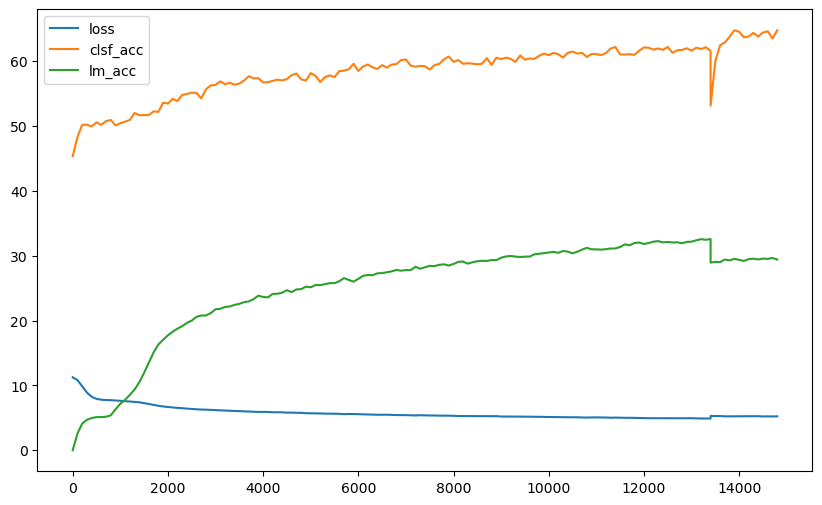

In [31]:
# For the last 10% of training, we use longer sequences. This is necessary to train the positional embeddings.
# We divide the batch size by 2 to avoid running out of memory and also scale the learning rate by 0.5.
loader_long = DataLoader(IMDbPairDataset(min_len=64, max_len=MAX_SEQ_LEN), batch_size=BATCH_SIZE // 2, num_workers=4)
hist2 = train_bert(bert_model, loader_long, masker,
                   device=device, num_iterations=int(0.1 * NUM_ITERATIONS), warmup_steps=0, log_every=100, lr=LR / 2)

torch.save(bert_model.state_dict(), 'BERT.pt')
torch.save(hist1, 'BERT_hist1.pt')
torch.save(hist2, 'BERT_hist2.pt')

# Combine the two training histories
hist2['iter'] += hist1['iter'][-1]
hist = {k: np.concatenate([v1, v2]) for k, v1, v2 in zip(hist1.keys(), hist1.values(), hist2.values())}
plt.figure(figsize=(10, 6))
plt.plot(hist['iter'], hist['loss'], label='loss')
plt.plot(hist['iter'], hist['clsf_acc'], label='clsf_acc')
plt.plot(hist['iter'], hist['lm_acc'], label='lm_acc')
plt.legend()

In [32]:
# The next sentence prediction accuracy (clsf_acc) should be at least 60% and the masked language model accuracy (lm_acc) should be at least 30%. However, you can easily achieve 70% and 40% respectively by training for a longer time.
bert_model.load_state_dict(torch.load('BERT.pt'))
validate_bert(bert_model, masker, device=device)

[nltk_data] Downloading package punkt to /home/felix/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Tokenizing imdb_test dataset...


  0%|                                                                                                                                                                                                                                               | 0/1000 [00:00<?, ?it/s]/home/felix/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:384: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987288773/work/aten/src/ATen/NestedTensorImpl.cpp:177.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 34.23it/s]


{'clsf_acc': 62.69218921661377, 'lm_acc': 32.57541358470917}

### Expected results

```
{'clsf_acc': 63.76405954360962, 'lm_acc': 32.96291530132294}
```

# Evaluating the model
As the downstream task we will use the Stanford Sentiment Treebank (SST-2) dataset. This dataset contains 10,000 sentences with labels 0 (negative) and 1 (positive).

`SST2Model` class: This class takes an instance of a `BERTEncoder` and initializes a linear classifier on top of the first token of the output of the encoder (like the next sentece classifier before). Optionally we want to be able to freeze the encoder and only train the classifier.
You can achieve this, by setting `param.requires_grad = train_encoder` for each parameter of the encoder or using `torch.no_grad()` when calling the encoder.

The dataset class, training and evaluation code is provided in utils.py

### Train the model on the SST-2 dataset.

We can try to train the encoder from scratch on the SST-2 dataset. However, even with more epochs you will have a hard time getting much more than 60% accuracy.

When we use the encoder pretrained on IMDb, we can get 70% accuracy in just 3 epochs with linear probing. Note that in the original paper, the authors fine-tune the whole model for the downstream tasks.


In [38]:
from utils import train_sst2, validate_sst2

model = BERT(**model_kwargs)
sst2_model_scratch = train_sst2(model.encoder, train_encoder=True, device=device, epochs=5, lr=5e-4)
val_acc_rand_init = validate_sst2(sst2_model_scratch, device=device)
print("Val acc from random initialization:", val_acc_rand_init)

model = BERT(**model_kwargs)
model.load_state_dict(torch.load('BERT.pt'))
sst2_model = train_sst2(model.encoder, train_encoder=False, device=device, epochs=3)

# You should get at least 70% accuracy on SST-2.
val_acc = validate_sst2(sst2_model, device=device)
print("Val accuracy:", val_acc)

Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [01:10<00:00,  3.77it/s, acc=0.601, loss=0.664]
[nltk_data] Downloading package punkt to /home/felix/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Tokenizing sst2_validation dataset...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 49.47it/s]


Val acc from random initialization: 59.51834321022034


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 52.11it/s]

Val accuracy: 70.6421971321106


### Expected result

```
Val acc from random initialization: 58.830273151397705
Val accuracy: 73.050457239151
```